In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import kagglehub
import os

In [174]:
path = kagglehub.dataset_download("nehalbirla/vehicle-dataset-from-cardekho")
df = pd.read_csv(os.path.join(path, "CAR DETAILS FROM CAR DEKHO.csv"), header=0)
print(path)

C:\Users\Eric\.cache\kagglehub\datasets\nehalbirla\vehicle-dataset-from-cardekho\versions\4


In [175]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [176]:
TARGET = 'selling_price'
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
NUMERICAL_FEATURES = df.select_dtypes(include=['number']).columns.tolist()

df[f'{TARGET}_original'] = df[TARGET]


print("Categorical variables:", CATEGORICAL_FEATURES)
print("Numeric variables:", NUMERICAL_FEATURES)

Categorical variables: ['name', 'fuel', 'seller_type', 'transmission', 'owner']
Numeric variables: ['year', 'selling_price', 'km_driven']


In [177]:
#replace 'name' column with 'brand' extracted from it to avoid high cardinality
df['brand'] = df['name'].str.split().str[0]
df.drop(columns=['name'], inplace=True)

#update Categorical Features
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical variables:", CATEGORICAL_FEATURES)


Categorical variables: ['fuel', 'seller_type', 'transmission', 'owner', 'brand']


In [178]:
df.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,selling_price_original,brand
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,60000,Maruti
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,135000,Maruti
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,600000,Hyundai
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,250000,Datsun
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,450000,Honda


In [179]:
# Remove Duplicates
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)

# Handle Missing Values
if df.isnull().sum().any():
    for col in NUMERICAL_FEATURES:
        df[col].fillna(df[col].median(), inplace=True)
    for col in CATEGORICAL_FEATURES:
        df[col].fillna(df[col].mode()[0], inplace=True)

In [180]:
before = df.shape[0]

for col in ['selling_price', 'km_driven']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print(f"{col} | lower: {lower:.2f}, upper: {upper:.2f}")
    
    # Filter out outliers
    df = df[(df[col] >= lower) & (df[col] <= upper)]

after = df.shape[0]
print(f"Removed {before - after} outliers from the dataset.")

selling_price | lower: -400000.00, upper: 1200000.00
km_driven | lower: -35507.50, upper: 165304.50
Removed 291 outliers from the dataset.


brand
Maruti           1040
Hyundai           613
Tata              288
Mahindra          269
Honda             209
Ford              201
Chevrolet         147
Toyota            109
Renault           106
Volkswagen         90
Nissan             50
Skoda              47
Fiat               31
Datsun             29
Mercedes-Benz       8
Audi                6
BMW                 6
Mitsubishi          3
Ambassador          3
OpelCorsa           2
Name: count, dtype: int64
Shape: (3259, 9)
year                      0
selling_price             0
km_driven                 0
fuel                      0
seller_type               0
transmission              0
owner                     0
selling_price_original    0
brand                     0
dtype: int64
count    3.259000e+03
mean     3.929040e+05
std      2.537223e+05
min      2.000000e+04
25%      1.950000e+05
50%      3.300000e+05
75%      5.500000e+05
max      1.200000e+06
Name: selling_price, dtype: float64


<Axes: >

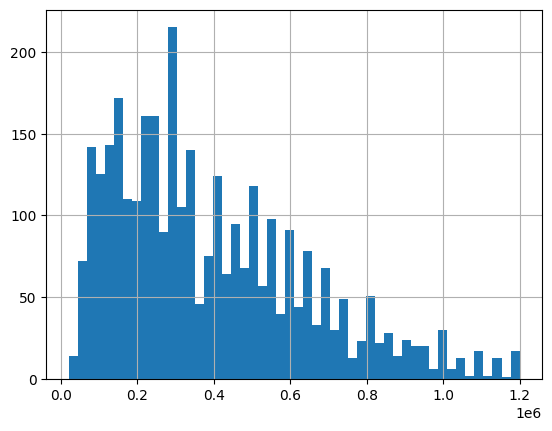

In [181]:
# confirm brand extraction worked
print(df['brand'].value_counts().head(20))

# inspect missing values and shapes
print("Shape:", df.shape)
print(df.isnull().sum())

# look at target distribution
print(df['selling_price'].describe())
df['selling_price'].hist(bins=50)


In [182]:
# One-Hot Encoding for Categorical Features
df_encoded = pd.get_dummies(df, columns=CATEGORICAL_FEATURES, drop_first=True, dtype=int)

# Identify the columns that need scaling (numerical, excluding the target)
features_to_scale = [col for col in df_encoded.columns if col in NUMERICAL_FEATURES]

# Scaling Numerical Features (Min-Max Scaling)
scaler = MinMaxScaler()

# Fit and transform the features, converting back to a DataFrame
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

In [183]:
df_encoded.to_csv("../data/processed_vehicles.csv", index=False)

In [184]:
df_encoded.head()

,year,selling_price,km_driven,selling_price_original,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,...,brand_Maruti,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_OpelCorsa,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen
0,0.535714,0.033898,0.424239,60000,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
1,0.535714,0.097458,0.303026,135000,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0.714286,0.491525,0.606058,600000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.892857,0.194915,0.278784,250000,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.785714,0.364407,0.854545,450000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
